### Strain measurements loading

In [1]:
# Importing the necessary libraries
import re 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Get all the file paths from the folder of a specific specimen
from utils.extract_strains import extract_strains

path = r'C:\Users\User\Desktop\experimental_campaign\L2-03\AI'
file_paths= []
for root, _, files in os.walk(path):
    file_paths.extend(os.path.join(root, name) for name in files)
file_paths.sort(key=lambda x: int(re.search(r'AI_(\d+)k', x).group(1)))

strains, change_points = extract_strains(file_paths[0])

# Create the average strain in each QS for each vFBG, shape (n_QS, 90)
for file in file_paths[1:]:
    data  = extract_strains(file, change_points)
    strains = pd.concat([strains,data[0]], axis=0, ignore_index=True)

# Export the strain measurements
specimen = re.search(r'\\([^\\]+)\\[AB]I$', path).group(1)
strains.to_csv(specimen+'_strains.csv', index=False, header=False)

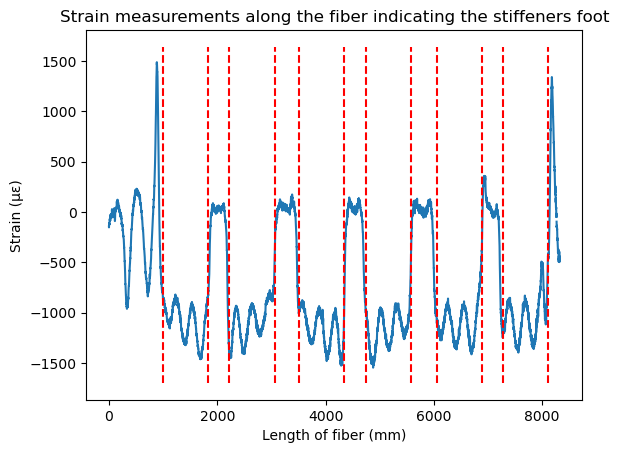

In [2]:
# FBG length
filename = 'data/L2-03_increment.csv'
strains = pd.read_csv(filename, header=None)

# 0.65 is the spatial resolution of the fiber
increment = np.arange(0, 0.65* (strains.shape[1]-1) + 0.65, 0.65)
strains.columns = increment
stiffener_feet = [997, 1831, 2224, 3058, 3515, 4344, 4751, 5584, 6051, 6880, 7280, 8109]

fig, ax = plt.subplots()
strains.iloc[15].T.plot(legend=False, ax=ax)
ylim = ax.get_ylim()
ax.vlines(stiffener_feet, ymin=min(ylim), ymax=max(ylim), color='r', linestyle='--')
ax.set_title('Strain measurements along the fiber indicating the stiffeners foot')
ax.set_xlabel('Length of fiber (mm)')
ax.set_ylabel('Strain (με)')
plt.show()

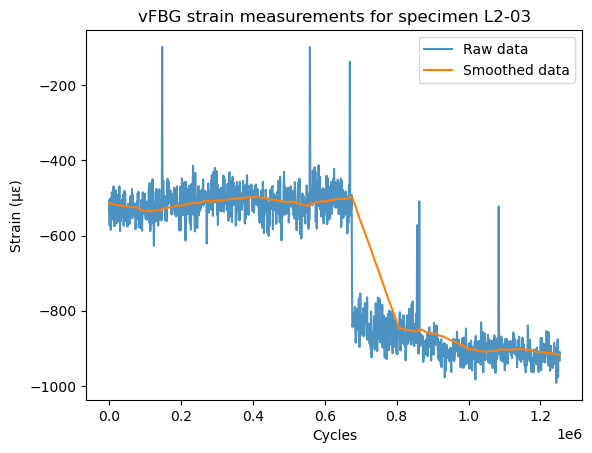

In [6]:
# Plot strains for one of the vFBGs of specimen L2-03
path = 'data'
filename = os.path.join(path, 'L2-03_strains.csv')
strains = pd.read_csv(filename, header=None)

strains_smoothed = strains.rolling(window=strains.shape[0]//10, min_periods=50).mean().dropna()
cycles = np.arange(1000*strains_smoothed.shape[0], step=1000)

fig, ax = plt.subplots()
ax.plot(cycles, strains[strains.shape[0]-strains_smoothed.shape[0]:][0], alpha=0.8, label='Raw data')
ax.plot(cycles, strains_smoothed[0], label='Smoothed data')
ax.set_title('vFBG strain measurements for specimen L2-03')
ax.set_xlabel('Cycles')
ax.set_ylabel('Strain (με)')
ax.legend()
plt.show()

### Feature engineering/ Health Indicator computation

In [7]:
from utils.HIs import hi1, hi2, hi_fused, vhi1, vhi2, higa
import json

path = 'data'
filename = os.path.join(path, 'vhi1_norm_params.json')
with open(filename, 'r') as f:
    params = json.load(f)

# Calculate the basic HIs
hi_1 = hi1(strains_smoothed)
hi_2 = hi2(strains_smoothed)
hi_3 = hi_fused(hi_1)
hi_4 = hi_fused(hi_2)
vhi_1 = vhi1(strains_smoothed, params)
vhi_2 = vhi2(strains_smoothed)

# Calculate the fused HI 
hi_ga = higa(hi_3, hi_4, vhi_1, vhi_2)

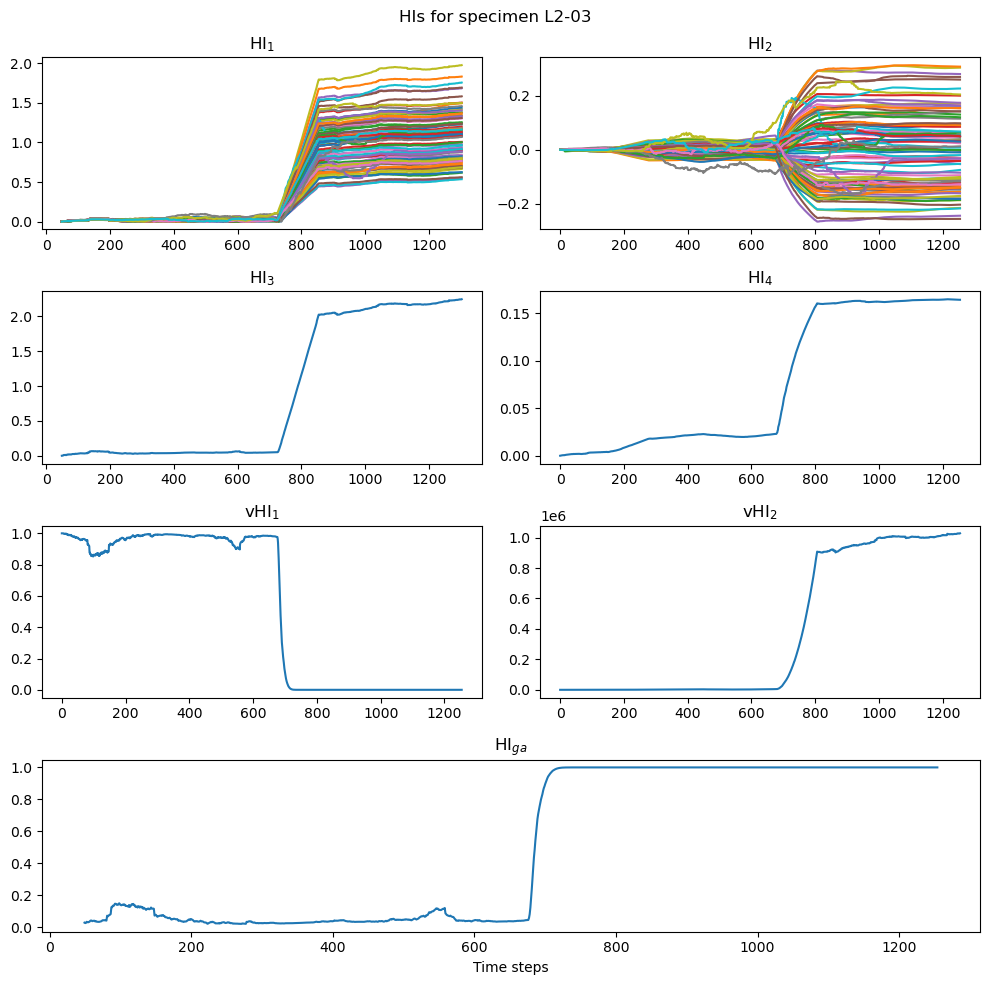

In [8]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, :])

ax1.plot(hi_1)
ax1.set_title(r'HI$_{1}$')
ax2.plot(hi_2)
ax2.set_title(r'HI$_{2}$')
ax3.plot(hi_3)
ax3.set_title(r'HI$_{3}$')
ax4.plot(hi_4)
ax4.set_title(r'HI$_{4}$')
ax5.plot(vhi_1)
ax5.set_title(r'vHI$_{1}$')
ax6.plot(vhi_2)
ax6.set_title(r'vHI$_{2}$')
ax7.plot(hi_ga)
ax7.set_title(r'HI$_{ga}$')
ax7.set_xlabel('Time steps')
fig.suptitle('HIs for specimen L2-03')
plt.tight_layout()

### Performance metrics for HIs

In [4]:
# Load the HIs for all the test specimens
import os 
import pandas as pd

path = 'data'
filename = os.path.join(path, 'L2_HIs.xlsx')
HIs = pd.read_excel(filename, sheet_name=None, names=['cycles', 'hi_3', 'hi_4', 'vhi_1', 'vhi_2', 'hi_ga'])

In [5]:
# Calculate the monotonicity 
from utils.metrics import monotonicity, prognosability

mono = pd.DataFrame()
for specimen, df in HIs.items():
    for hi in HIs[specimen].columns[1:]:
        mono.at[specimen, hi] = monotonicity(df[hi])

In [6]:
# Calculate the prognosability
hi_values = []
for key, df in HIs.items():
    hi_start = df.iloc[0, 1:].values
    hi_end = df.iloc[-1, 1:].values
    hi_values.append({'specimen': key, 'hi_start': hi_start, 'hi_end': hi_end})
hi_values = pd.DataFrame(hi_values)
hi_values.set_index('specimen', inplace=True)

prog = prognosability(hi_values['hi_start'].values, hi_values['hi_end'].values)

In [12]:
import plotly.graph_objects as go
layout = {'width':800, 'height':500}
fig = go.Figure()
fig.add_trace(go.Bar(x=mono.columns, y=mono.mean(axis=0), name='Monotonicity', marker_color='#808183', hovertemplate='%{y:.2f}'))
fig.add_trace(go.Bar(x=mono.columns, y=prog, name='Prognosability', marker_color='#799ed3', hovertemplate='%{y:.2f}'))
fig.update_layout(barmode='group', title='Prognostic Attributes', **layout)
fig.show()

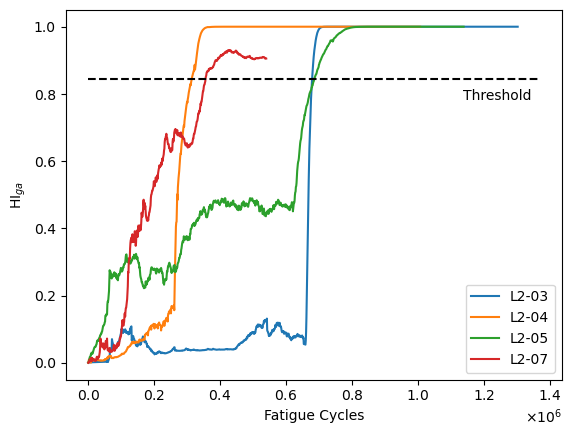

In [14]:
# Focusing on the advanced HI proposed
from utils.figures import plot_hi_ga
Xtest = {specimen: HIs[specimen].hi_ga for specimen in HIs.keys()}
Ytest = {specimen: HIs[specimen].cycles[::-1] for specimen in HIs.keys()}

fig, ax = plot_hi_ga(Xtest, Ytest)
xlim = ax.get_xlim()
ax.hlines(0.845, 0, max(xlim), colors='k', linestyles='--', label='Threshold')
fig.text(0.8, 0.7, 'Threshold', fontsize=10, color='k', ha='center', va='center')
plt.show()

### Final prognostic feature

In [1]:
# Loading cycles, hi_ga for all specimens, both L1 and L2
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.load_data import load_data

path = 'data'
filename = os.path.join(path, 'specimens_hi_ga.xlsx')
# Load, preprocess the data
Xtrain, Ytrain, Xtest, Ytest, [train_specimens, test_specimens] = load_data(filename, threshold=0.845)
print(f'L1 specimens to be used for model training: {train_specimens}')
print(f'L2 specimens to be tested: {test_specimens}')

L1 specimens to be used for model training: ['ca_1', 'ca_2', 'ca_3', 'ca_4', 'va_1', 'va_2', 'va_3', 'va_4', 'va_5', 'sp_1', 'sp_2', 'sp_3', 'sp_4', 'sp_5', 'sp_7']
L2 specimens to be tested: ['L2-03', 'L2-04', 'L2-05', 'L2-07']


In [17]:
# With the threshold set to 0.845, we can calculate again the metrics of the advanced HI
from utils.metrics import monotonicity, prognosability

# Monotonicity
mon = []
for specimen, hi_ga in Xtest.items():   
    print(f"Monotonicity of {specimen} hi_ga: {monotonicity(hi_ga):.2f}")
    mon.append(monotonicity(hi_ga))

print(f"Average monotonicity : {np.mean(mon):.2f}")

# Prognosability
hi_start = np.array([hi_ga.iloc[0] for hi_ga in Xtest.values()])
hi_end = np.array([hi_ga.iloc[-1] for hi_ga in Xtest.values()])

def prognosability(hi_start, hi_end):
    return np.exp(-np.std(hi_end) / np.mean(np.abs(hi_end-hi_start)))

print(f"Prognosability: {prognosability(hi_start, hi_end):.2f}")

Monotonicity of L2-03 hi_ga: 0.52
Monotonicity of L2-04 hi_ga: 0.90
Monotonicity of L2-05 hi_ga: 0.58
Monotonicity of L2-07 hi_ga: 0.85
Average monotonicity : 0.71
Prognosability: 1.00


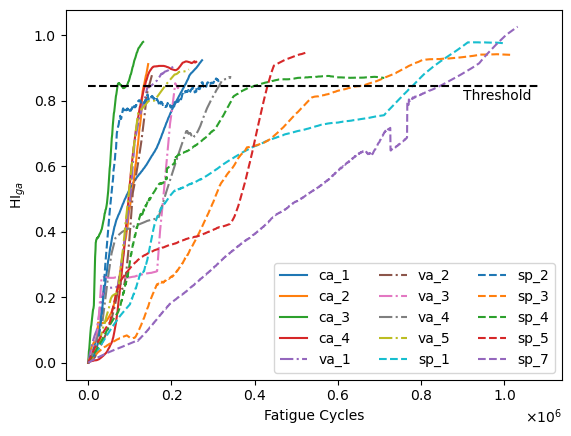

In [18]:
# Plot the advanced HI for training specimens
from utils.figures import plot_hi_ga
linestyle = {'ca': '-', 'va': '-.', 'sp': '--'}
fig, ax = plot_hi_ga(Xtrain, Ytrain, linestyle=linestyle, ncols=3)
xlim = ax.get_xlim()
ax.hlines(0.845, 0, max(xlim), colors='k', linestyles='--', label='Threshold')
fig.text(0.8, 0.7, 'Threshold', fontsize=10, color='k', ha='center', va='center')
plt.show()

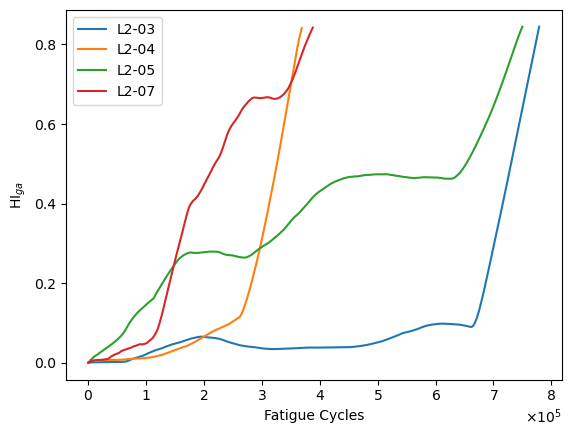

In [19]:
# Plot the advanced HI for test specimens
fig, ax = plot_hi_ga(Xtest, Ytest, legend_loc='upper left')

### Remainig Useful Life estimation results

In [2]:
# Dynamic weights
from utils.dynamic_weigths import weight_calculation
weights = weight_calculation(Xtrain, Xtest)

print(f'Initial sequences length of train dataset: {[len(hi) for hi in Xtrain.values()]}')
print(f'Initial sequences length of test dataset: {[len(hi) for hi in Xtest.values()]}')
print(f'Weight size for test dataset: {[weights[test].shape for test in test_specimens]}')

Initial sequences length of train dataset: [494, 261, 239, 469, 409, 311, 436, 687, 485, 1593, 503, 1614, 1130, 835, 1639]
Initial sequences length of test dataset: [780, 370, 751, 389]
Weight size for test dataset: [(15, 780), (15, 370), (15, 751), (15, 389)]


In [3]:
# Load the trained SVR models
import pickle
path = 'models'
filename = os.path.join(path, 'svr_models.pkl')
with open(filename, 'rb') as f:
    svr_models = pickle.load(f)

In [4]:
# Load the trained LSTMN models and the scaler
from keras.models import load_model
path = 'models/lstmn_models'
lstmn_models = {specimen: load_model(os.path.join(path, f'{specimen}_lstmn_model.keras')) for specimen in train_specimens}

with open('models/scaler.pkl', 'rb') as f:
    Yscaler = pickle.load(f)

In [ ]:
# Model comparison
from scipy.stats import bootstrap
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from utils.metrics import cumulative_relative_accuracy, confidence_interval_distance_convergence, percent_in_bounds

class Metric:
    def __init__(self, name):
        self.name = name
        self.value = {'svr': [], 'lstmn': []}

    def __str__(self):
        return f'{self.name}: {self.value:.2f}'

rmse = Metric('RMSE')
mae = Metric('MAE')
mape = Metric('MAPE')
cra = Metric('CRA')
cidc = Metric('CIDC')
pib = Metric('PIB')

# Metrics evaluation for SVR
for specimen in test_specimens:
    Xt = Xtest[specimen].values.reshape(-1,1)
    yt = Ytest[specimen]
    
    predicted_rul = [svr_models[specimen].predict(Xt) for specimen in train_specimens]
    weighted_rul = [weights[specimen][i] * predicted_rul[i] for i, _ in enumerate(train_specimens)]
    
    y_pred = np.mean(weighted_rul, axis=0)
    weighted_rul = np.array(weighted_rul).reshape(1,15,-1)
    lower, upper = bootstrap(weighted_rul, np.mean, n_resamples=1000, method='percentile').confidence_interval
    
    # Absolute error metrics
    rmse.value['svr'].append(mean_squared_error(yt, y_pred, squared=False))
    mae.value['svr'].append(mean_absolute_error(yt, y_pred))

    # Relative error metrics
    mape.value['svr'].append(mean_absolute_percentage_error(yt[:-1], y_pred[:-1]))
    cra.value['svr'].append(cumulative_relative_accuracy(yt, y_pred))

    # Confidence intervals metrics
    cidc.value['svr'].append(confidence_interval_distance_convergence(lower, upper))
    pib.value['svr'].append(percent_in_bounds(yt, lower, upper))

# Metrics evaluation for LSTMN
for specimen in test_specimens:
    Xt = Xtest[specimen].values.reshape(1,-1,1)
    yt = Ytest[specimen]

    predicted_rul = [lstmn_models[specimen].predict(Xt).reshape(-1,) for specimen in train_specimens]
    weighted_rul = [weights[specimen][i] * predicted_rul[i] for i, _ in enumerate(train_specimens)]
    weighted_rul = [Yscaler.inverse_transform(y.reshape(-1,1)).reshape(-1,) for y in weighted_rul]

    y_pred = np.mean(weighted_rul, axis=0)
    weighted_rul = np.array(weighted_rul).reshape(1,15,-1)
    lower, upper = bootstrap(weighted_rul, np.mean, n_resamples=1000, method='percentile').confidence_interval
    
    # Absolute error metrics
    rmse.value['lstmn'].append(mean_squared_error(yt, y_pred, squared=False))
    mae.value['lstmn'].append(mean_absolute_error(yt, y_pred))

    # Relative error metrics
    mape.value['lstmn'].append(mean_absolute_percentage_error(yt[:-1], y_pred[:-1]))
    cra.value['lstmn'].append(cumulative_relative_accuracy(yt, y_pred))

    # Confidence intervals metrics
    cidc.value['lstmn'].append(confidence_interval_distance_convergence(lower, upper))
    pib.value['lstmn'].append(percent_in_bounds(yt, lower, upper))

In [6]:
from utils.figures import plot_metric
fig = plot_metric(rmse,['svr','lstmn'], test_specimens)
layout = {'width':870, 'height':500}
fig.update_layout(layout)
fig.show()

In [7]:
from utils.figures import plot_metric
fig = plot_metric(mae,['svr','lstmn'], test_specimens)
layout = {'width':870, 'height':500}
fig.update_layout(layout)
fig.show()

In [8]:
from utils.figures import plot_metric
fig = plot_metric(mape,['svr','lstmn'], test_specimens)
layout = {'width':870, 'height':500}
fig.update_layout(layout)
fig.show()

In [9]:
from utils.figures import plot_metric
fig = plot_metric(cra,['svr','lstmn'], test_specimens)
layout = {'width':870, 'height':500}
fig.update_layout(layout)
fig.show()

In [10]:
from utils.figures import plot_metric
fig = plot_metric(cidc,['svr','lstmn'], test_specimens)
layout = {'width':870, 'height':500}
fig.update_layout(layout)
fig.show()

In [11]:
from utils.figures import plot_metric
fig = plot_metric(pib,['svr','lstmn'], test_specimens)
layout = {'width':870, 'height':500}
fig.update_layout(layout)
fig.show()